In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
# group.add_argument("--seed", type=int, default=0)
# group.add_argument("--save_dir", type=str, default=None)

# group = parser.add_argument_group("model")
# group.add_argument("--sim", type=str, default='boids')

# group = parser.add_argument_group("data")
# group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

# group = parser.add_argument_group("optimization")
# group.add_argument("--k_nbrs", type=int, default=2)
# group.add_argument("--bs", type=int, default=32)
# group.add_argument("--pop_size", type=int, default=1024)
# group.add_argument("--n_iters", type=int, default=10000)
# group.add_argument("--sigma1", type=float, default=0.1)
# group.add_argument("--sigma2", type=float, default=0.)

In [5]:
import main_illuminate
cfg_default = vars(main_illuminate.parse_args(""))
cfg_default

{'seed': 0,
 'save_dir': None,
 'sim': 'boids',
 'clip_model': 'clip-vit-base-patch32',
 'k_nbrs': 2,
 'bs': 32,
 'pop_size': 1024,
 'n_iters': 10000,
 'sigma1': 0.1,
 'sigma2': 0.0}

In [ ]:
# cfg_default = dict(
#     seed=0, save_dir=None,
#     sim='lenia',
#     k_nbrs=2, bs=32 pop_size=1024, n_iters=10000,
#     sigma1=0.1, sigma2=0.0,
# )

seed_sweep = np.arange(1)
# clip_sweep = np.logspace(np.log10(0.01), np.log10(1.), num=16)
# sim_sweep = ['lenia_1.0', 'boids', 'plife_ba']
sim_sweep = ['lenia_1.0', 'boids']
clip_model_sweep = ['clip-vit-base-patch32', 'dinov2-base', 'pixels']

cfgs = []
for seed in seed_sweep:
    for sim in sim_sweep:
        for clip_model in clip_model_sweep:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, sim=sim, clip_model=clip_model)
            cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/illumination_dino/{seed}_{sim}_{clip_model}")
            cfgs.append(cfg)
print(len(cfgs))

6


In [7]:
commands = experiment_utils.create_commands(cfgs, prefix='python main_illuminate.py', out_file='../science_scripts/illumination_dino.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python main_illuminate.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination_dino/0_lenia_1.0_clip-vit-base-patch32" --sim="lenia_1.0" --clip_model="clip-vit-base-patch32" --k_nbrs=2 --bs=32 --pop_size=1024 --n_iters=10000 --sigma1=0.1 --sigma2=0.0
python main_illuminate.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination_dino/0_lenia_1.0_dinov2-base"           --sim="lenia_1.0" --clip_model="dinov2-base"           --k_nbrs=2 --bs=32 --pop_size=1024 --n_iters=10000 --sigma1=0.1 --sigma2=0.0
python main_illuminate.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/illumination_dino/0_lenia_1.0_pixels"                --sim="lenia_1.0" --clip_model="pixels"                --k_nbrs=2 --bs=32 --pop_size=1024 --n_iters=10000 --sigma1=0.1 --sigma2=0.0 
...
6 commands


# Results

In [7]:
import jax
import jax.numpy as jnp
from jax.random import split
import copy
from umap import UMAP
import imageio
import evosax

from create_sim import create_sim, rollout_simulation, rollout_and_embed_simulation, FlattenSimulationParameters

from models.models_nca import NCA
from models.models_dnca import DNCA
from models.models_boids import Boids
from models.models_plife import ParticleLife
from models.models_lenia import Lenia
from models.models_plenia import ParticleLenia
from models.models_gol import GameOfLife


from clip_jax import MyFlaxCLIP
clip_model = MyFlaxCLIP()

2024-12-17 02:00:46.173297: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
import matplotlib.font_manager as fm
font_directory = '/home/akarsh_sakana_ai/nca-alife/fonts/go'
for font_file in os.listdir(font_directory):
    print(font_file)
    if font_file.endswith('.ttf'):
        font_path = os.path.join(font_directory, font_file)
        fm.fontManager.addfont(font_path)

Go-Medium-Italic.ttf
Go-Medium.ttf
Go-Regular.ttf
Go-Mono-Bold.ttf
Go-Smallcaps-Italic.ttf
Go-Smallcaps.ttf
Go-Mono-Italic.ttf
Go-Mono-Bold-Italic.ttf
Go-Italic.ttf
Go-Bold.ttf
Go-Mono.ttf
GO.txt
Go-Bold-Italic.ttf


In [8]:
data = []
for iplt, cfg in enumerate(cfgs):
    sim = FlattenSimulationParameters(create_sim(cfg['sim']))
    rollout_fn = jax.jit(partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final'))

    pop = util.load_pkl(cfg['save_dir'], 'pop')
    params = pop['params'][:64]

    rng = jax.random.PRNGKey(0)
    rollout_data = [rollout_fn(rng, p) for p in tqdm(params)]
    rollout_data = jax.tree.map(lambda *x: jnp.stack(x, axis=0), *rollout_data)
    data.append(rollout_data)

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

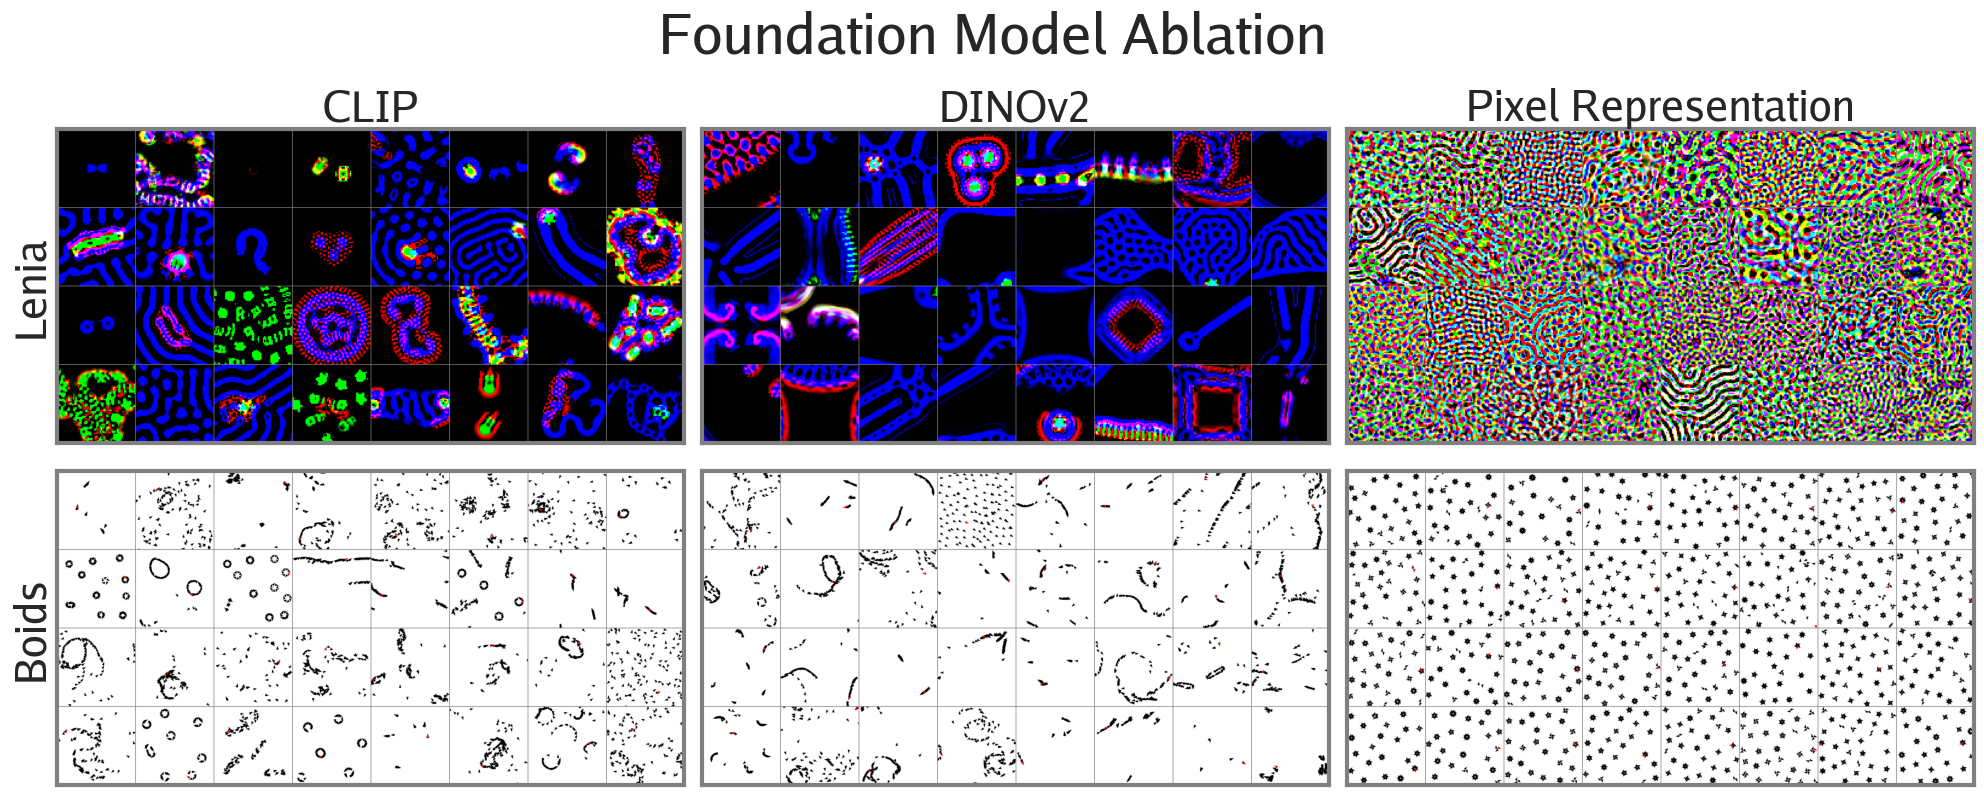

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8.5))
seed = 0
for iplt, cfg in enumerate(cfgs):
    rollout_data = data[iplt]

    img = rollout_data['rgb'][4*8*seed:4*8*(seed+1)]
    img = jnp.pad(img, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
    img = rearrange(img, "(R C) H W D -> (R H) (C W) D", C=8)

    plt.sca(axs.flatten()[iplt])
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])

    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(3)

axs[0, 0].set_title('CLIP', fontsize=30, fontname="Go")
axs[0, 1].set_title('DINOv2', fontsize=30, fontname="Go")
axs[0, 2].set_title('Pixel Representation', fontsize=30, fontname="Go")
axs[0, 0].set_ylabel('Lenia', fontsize=30, fontname="Go")
axs[1, 0].set_ylabel('Boids', fontsize=30, fontname="Go")
plt.suptitle("Foundation Model Ablation", fontsize=40, fontname="Go")
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/fm_ablation.pdf", format='pdf', dpi=300)
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/fm_ablation.png", format='png', dpi=300)
plt.show()

In [13]:
data = []
for iplt, cfg in enumerate(cfgs):
    sim = FlattenSimulationParameters(create_sim(cfg['sim']))
    rollout_fn = jax.jit(partial(rollout_simulation, sim=sim, img_size=64, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='video'))

    pop = util.load_pkl(cfg['save_dir'], 'pop')
    params = pop['params'][:64]

    rng = jax.random.PRNGKey(0)
    rollout_data = [rollout_fn(rng, p) for p in tqdm(params)]
    rollout_data = jax.tree.map(lambda *x: jnp.stack(x, axis=0), *rollout_data)
    rollout_data['rgb'] = jax.image.resize(rollout_data['rgb'], (64, 1000, 64, 64, 3), method='bilinear')
    data.append(rollout_data)

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/64 [00:00<?, ?it/s]

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8.5))
seed = 0
aximgs = []
for iplt, cfg in enumerate(cfgs):
    rollout_data = data[iplt]

    img = rollout_data['rgb'][4*8*seed:4*8*(seed+1), 0]
    img = jnp.pad(img, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
    img = rearrange(img, "(R C) H W D -> (R H) (C W) D", C=8)

    plt.sca(axs.flatten()[iplt])
    aximgs.append(plt.imshow(img))
    plt.grid(False)
    plt.xticks([]); plt.yticks([])

    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(3)

axs[0, 0].set_title('CLIP', fontsize=30, fontname="Go")
axs[0, 1].set_title('DINOv2', fontsize=30, fontname="Go")
axs[0, 2].set_title('Pixel Representation', fontsize=30, fontname="Go")
axs[0, 0].set_ylabel('Lenia', fontsize=30, fontname="Go")
axs[1, 0].set_ylabel('Boids', fontsize=30, fontname="Go")
plt.suptitle("Foundation Model Ablation", fontsize=40, fontname="Go")
plt.tight_layout()

# plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs/fm_ablation.pdf", format='pdf', dpi=300)

from matplotlib.animation import FuncAnimation, FFMpegWriter
def update(timestep):
    if timestep%100==0:
        print(timestep)
    timestep = timestep*4
    for iplt, aximg in enumerate(aximgs):
        rollout_data = data[iplt]

        img = rollout_data['rgb'][4*8*seed:4*8*(seed+1), timestep]
        img = jnp.pad(img, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
        img = rearrange(img, "(R C) H W D -> (R H) (C W) D", C=8)

        aximg.set_data(img)
    return aximgs

ani = FuncAnimation(fig, update, frames=250, interval=66.66)
# ani.save("/home/akarsh_sakana_ai/nca-alife-data/figs_vids/supervised_3x6.gif", dpi=300)
writervideo = FFMpegWriter(fps=15)
# writervideo = ImageMagickWriter(fps=30)
ani.save("/home/akarsh_sakana_ai/nca-alife-data/figs_final/fm_ablation.mp4", writer=writervideo)
plt.close()

0
0
100
200
